# 군집별

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
df = pd.read_csv('./dataset/must_use_final.csv')

In [75]:
# 2. TIMESTAMP 정렬 및 선박별 정렬
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'TIMESTAMP'])

In [141]:
shift_steps = 18
features = ['LAT', 'LON', 'COG', 'HEADING']
for col in features:
    df[f'{col}_t-72'] = df.groupby('CLUSTER_1')[col].shift(shift_steps)

In [143]:
# 4. 입력(X), 출력(y=CLUSTER_1) 설정
X = df[[f'{col}_t-72' for col in features]]
y = df['CLUSTER_1']

In [145]:
# 5. 결측치 제거
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
non_null_index = X.dropna().index
X = X.loc[non_null_index]
y = y.loc[non_null_index]

In [147]:
# 6. 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [149]:
# 7. Soft Voting Classifier 정의
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression(max_iter=1000)
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('lr', lr_clf)],
    voting='soft'
)

In [151]:
voting_clf.fit(X_train, y_train)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lr', LogisticRegression(max_iter=1000))],
                 voting='soft')

In [153]:
# 9. 예측
y_pred = voting_clf.predict(X_test)

In [159]:
# 10. 성능 평가 출력
print("✅ 정확도:", accuracy_score(y_test, y_pred))
print("\n📊 분류 리포트:\n", classification_report(y_test, y_pred))

✅ 정확도: 0.9066055469445635

📊 분류 리포트:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       771
           1       0.82      0.90      0.86      5658
           2       0.92      0.96      0.94      8724
           3       0.94      0.98      0.96      5089
           4       0.87      0.85      0.86      2934
           5       0.94      0.57      0.71      1264
           6       0.94      0.81      0.87      3834
           7       0.99      0.97      0.98      2049

    accuracy                           0.91     30323
   macro avg       0.93      0.88      0.89     30323
weighted avg       0.91      0.91      0.90     30323



C:\Users\user\AppData\Local\Temp\ipykernel_67516\3179448419.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


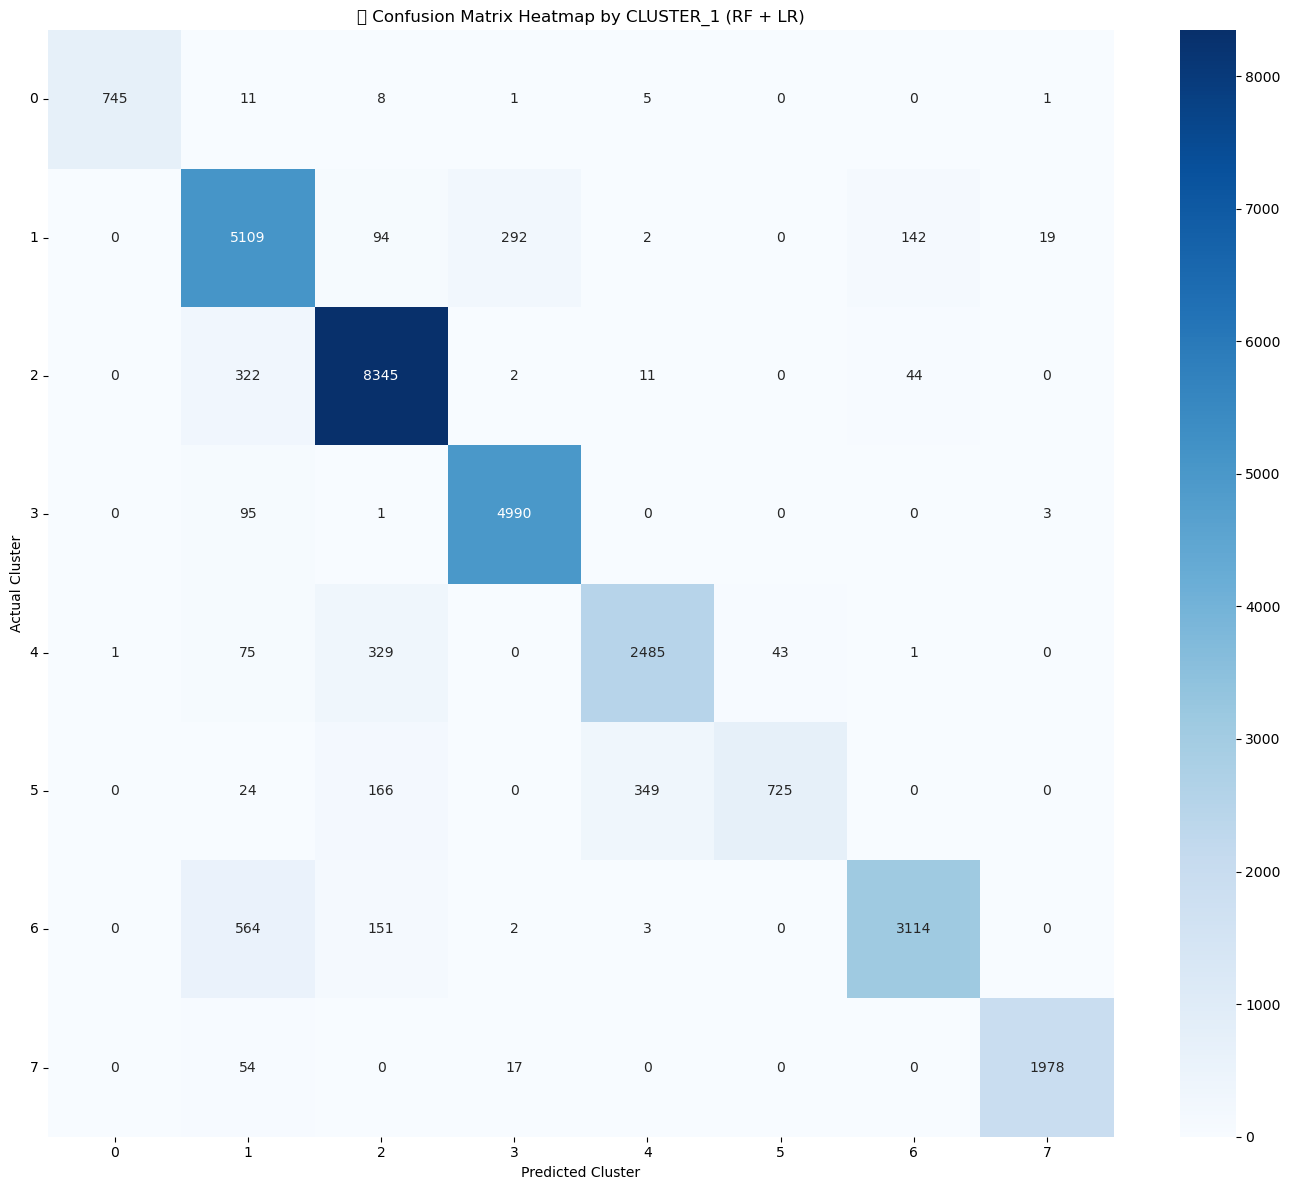

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. 혼동 행렬 계산 (군집 번호 기준 라벨 정렬)
labels = voting_clf.classes_  # 학습된 모델에서 클래스 자동 추출 (CLUSTER_1 기준)
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

# 2. 시각화용 DataFrame으로 변환
conf_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# 3. 시각화: 숫자 포함 heatmap
plt.figure(figsize=(14, 12))  # 크기 조절
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')  # 정수형으로 숫자 표시
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Cluster')
plt.title('📊 Confusion Matrix Heatmap by CLUSTER_1 (RF + LR)')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()